# Comparing Weights

This program analyzes whether there is a difference between the likehlihood of a given step taken by the Trajectory object (which has designed the weights to return it's walker back to the original position) and the "natural" likelihood calculated by performing many truly random walks that just happen to return to their original position.  
I chose to use Amax = 9 since it's small
10^8 random walks were generated and their values of p,q, and n at each timestep a were saved in a text file.  
The theoretical weights for each a,p,q,n, and Amax are stored in a directory near here.  
This program finds the average absolute for each value of (a,p,q,n) and stores that in an array.  
It visualizes the errors with some histograms at the end.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import progressbar
import os

In [2]:
Amax = 9 #Generated trajectories with an Amax of 9
random_walks = np.loadtxt("rand_traj/good_random_traj_"+str(Amax)+".txt", dtype=int,skiprows=1)

Our weights depend on where you are, where you're going to, how many copies of the multiplet you have, and how far along in the walk you are (number of gluons added --> a). These are all the possible values we can iterate over, most of them will be thrown out.

In [3]:
possible_a = np.array(range(1,Amax)) #not interested in a=0 since that's constrained to always go to (1,1)
possible_p = np.array(range(np.amax(random_walks[:,1])+1))
possible_q = np.array(range(np.amax(random_walks[:,2])+1))
possible_n = np.array(range(1,np.amax(random_walks[:,3])+1))

dp = [2, 1, 0, -1, -2, 1, -1]
dq = [-1, 1, 0, 2, 1, -2, -1] #used for finding possible multiplets

It's regrettable, but i couldn't find good way to get the Tpqlist object in a format python can understand.  
Thus, we need to recalculate what multiplets are allowed.

In [7]:
def get_good_pq(p_given,q_given,delta_p,delta_q,maxval):
    
    #function for finding the allowed multiplets to jump too
    
    good_pq = []
    for i in range(len(dp)):
        p_new = p_given - delta_p[i];
        q_new = q_given - delta_q[i];
        
        if ((p_new >= 0) & (q_new >= 0) & (p_new <= maxval) & (q_new <= maxval)):
            good_pq.append((p_new,q_new))
    return good_pq

This is the bulk of the code.  
It's purpose is describe at the top and details are in the comments, but I want to make a note of three possible error values:  
An error of -1 comes from (p,q) being the boring one (0,0) which is constrained to always go to (1,1), so we're throwing that out.  
If the error is -2, then the configuration of (p,q) being tested doesn't appear in the walks. This means that this isn't a valid configuratiof of (p,q), so this is made a note of to throw out later.
An error of -3 comes from if the random walker doesn't find all the possible theoretical (p', q') that one can get to from (p,q). This is possible in some of the rarer multiplets that the walker won't reach often. I don't know how to handle these cases, so they're being thrown out for now.

In [9]:
total_combinations = possible_a.size * possible_p.size * possible_q.size * possible_n.size
error_array = np.zeros((total_combinations, 5))

bar = progressbar.ProgressBar(maxval=total_combinations,widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
s = time.time()

num_iter = 0

#iterating over all possible values:
for a in possible_a:    
    for p in possible_p:       
        for q in possible_q:
            for n in possible_n:
        
                error_array[num_iter,0],error_array[num_iter,1],error_array[num_iter,2],error_array[num_iter,3] = a,p,q,n         
                
                #(0,0) is predetermined, so we're skipping it
                if (p==0)&(q==0):
                    error_array[num_iter,4] = -1
                    num_iter +=1
                    bar.update(num_iter)
                    continue                
                
                #this block of code finds where this combination of variables appears in our random walks
                matching_indicies = []
                mask = (random_walks[:,0] == a) & (random_walks[:,1] == p) & (random_walks[:,2] == q) & (random_walks[:,3] == n)
                for i in range(mask.size): 
                    if mask[i] == True:
                        matching_indicies.append(i)
    
                if (len(matching_indicies) == 0): #if there are no instances of this combination, make a 'note' of that to throw
                    error_array[num_iter,4] = -2  #it out later
                    num_iter += 1
                    bar.update(num_iter)
                    continue   

                goodpq = get_good_pq(p,q,dp,dq,np.amax(possible_p)) #grab the possible multiplets we can jumpt too
                number_events = [0]*len(goodpq)                     #a place to store how many times that jump is made
                random_events_weights_dict = dict(zip(goodpq,number_events))#dictionary to treat these as one object

                for k in matching_indicies:     #find how many times each "jump" was made
                    p_next, q_next = random_walks[k+1,1], random_walks[k+1,2]
                    random_events_weights_dict[(p_next,q_next)] += 1./len(matching_indicies)
                
                #grab the weights we calculated
                calculated_weights = np.loadtxt("/home/thomas/Research/MSU Pratt Project/fluxtubes/thomasrun/test_rand_step/calculated_weights/weights_"+str(a)+"_"+str(p)+"_"+str(q)+"_"+str(n)+"_"+str(Amax)+"_.txt",skiprows=1)
                
                #sometimes, the walker doesn't explore all the possible options
                #since we are limited by not taking an hour to run
                #so there is a mismatch between the number of calculated and 'true' weights
                #we deal with that error here:
                if(calculated_weights.shape[0] != len(goodpq)):
                    error_array[num_iter,4] = -3
                    num_iter +=1
                    bar.update(num_iter)
                    continue
                
                #find the absolute error between the calculated and "real" weights differ
                total_err = 0
                for l in range(calculated_weights.shape[0]):
                    p_curr = calculated_weights[l,0]
                    q_curr = calculated_weights[l,1]
                    rel_err = np.abs(calculated_weights[l,2] - random_events_weights_dict[(p_curr,q_curr)])
                    total_err += rel_err

                average_err = total_err/calculated_weights.shape[0] # calculate the average error
                error_array[num_iter,4] = average_err
                num_iter +=1
                
                bar.update(num_iter)

e=time.time()
bar.finish()
print(str(np.round(e-s,2))+" seconds")

5088.07 seconds


In [31]:
valid_error_array = error_array[(error_array[:,4]>=0)&(error_array[:,0]<6),:] #we consider all our "valid trajectories"

Analysis shows "n" and a do not appear to have a large impact on the error.

In [44]:
valid_error_array_copy = valid_error_array.copy()
pq_err = set()

for p in valid_error_array_copy[:,1]:
    for q in valid_error_array_copy[:,2]:
        curr_err = valid_error_array_copy[(valid_error_array_copy[:,1] == p) & (valid_error_array_copy[:,2] == q),:].copy()
        if curr_err.size == 0:
            continue
        avg_err = np.average(curr_err[:,4])
        pq_err.add((p,q,avg_err))
pq_err

{(0.0, 3.0, 0.028077500929227433),
 (1.0, 1.0, 0.013966021202842861),
 (1.0, 4.0, 0.03682998812595111),
 (2.0, 2.0, 0.0193223307537283),
 (3.0, 0.0, 0.02969573731235306),
 (3.0, 3.0, 0.033601285080179205),
 (4.0, 1.0, 0.037262673316360614),
 (4.0, 4.0, 0.0915553948557523)}

In [51]:
pq_2d_err=np.zeros((len(pq_err),3))
i = 0
for el in pq_err:
    for j in range(len(el)):
        pq_2d_err[i,j] = el[j]
    i += 1
pq_2d_err=pq_2d_err[pq_2d_err[:,0].argsort()]
pq_2d_err

array([[0.        , 3.        , 0.0280775 ],
       [1.        , 4.        , 0.03682999],
       [1.        , 1.        , 0.01396602],
       [2.        , 2.        , 0.01932233],
       [3.        , 0.        , 0.02969574],
       [3.        , 3.        , 0.03360129],
       [4.        , 4.        , 0.09155539],
       [4.        , 1.        , 0.03726267]])

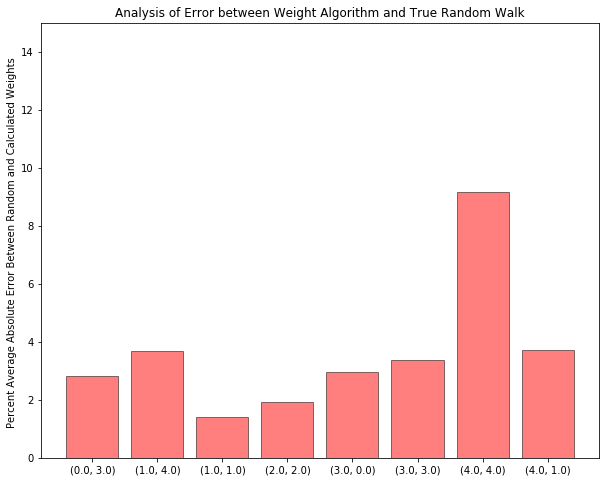

In [55]:
objects= []
for i in range(pq_2d_err.shape[0]):
    objects.append(str((pq_2d_err[i,0],pq_2d_err[i,1])))
y_pos = np.arange(len(objects))
er = pq_2d_err[:,2]*100

plt.figure(figsize=(10,8))
plt.bar(y_pos, er, align='center', alpha=0.5, edgecolor="black", color="red")
plt.xticks(y_pos, objects)
plt.ylabel('Percent Average Absolute Error Between Random and Calculated Weights ')
plt.title('Analysis of Error between Weight Algorithm and True Random Walk')
plt.ylim((0,15))
plt.show()